# ДЗ 12: RAG-система + Langfuse

**Цель:** RAG на новостном датасете с полной инструментацией Langfuse.

**Этапы:**
1. RAG-система — ответы на вопросы по новостям
2. Langfuse — Traces, Spans, Generations, Events, Scores
3. Datasets + Experiment с evaluator
4. Тестирование и анализ метрик

> Датасет: Lenta.ru / ru_news. Модель: gpt-4o-mini (AITunnel)

## 0. Установка зависимостей

In [1]:
%pip -q install -U \
  langchain langchain-classic langchain-community langchain-openai \
  chromadb sentence-transformers \
  langfuse \
  python-dotenv requests pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.3/420.3 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.

In [2]:
# Для ru_news — опционально
%pip -q install -U huggingface_hub zstandard jsonlines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pydantic<=2.12.3,>=2.0, but you have pydantic 2.12.5 which is incompatible.


## 1. Конфигурация и загрузка датасета

In [3]:
import os
from getpass import getpass
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
# надоело вбивать

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "sk-aitunnel-yJoIOQPK7e25oGDMshpYQuK95p9LBEpP"
if not os.environ.get("OPENAI_BASE_URL"):
    os.environ["OPENAI_BASE_URL"] = "https://api.aitunnel.ru/v1/"

if not os.environ.get("LANGFUSE_SECRET_KEY"):
    os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-a4454dd1-4216-4581-a5e2-50ee235a500a"
if not os.environ.get("LANGFUSE_PUBLIC_KEY"):
    os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-47e2ffa6-422b-4a19-9871-6b10af2fb385"
if not os.environ.get("LANGFUSE_BASE_URL"):
    os.environ["LANGFUSE_BASE_URL"] = "https://cloud.langfuse.com"

In [4]:
import csv
import io
import gzip
import json
import requests

N_DOCS = 1500
DATASET_MODE = "ru_news"  # ru_news | lenta

texts = []
labels = []


def fill_from_rows(rows):
    for row in rows:
        title = (row.get("title") or "").strip()
        body = (row.get("text") or "").strip()
        topic = (row.get("topic") or "unknown").strip()
        if not body:
            continue
        texts.append(f"{title}. {body}" if title else body)
        labels.append(topic)
        if len(texts) >= N_DOCS:
            break


def fill_from_ru_news(lines):
    for line in lines:
        try:
            obj = json.loads(line)
            title = (obj.get("title") or "").strip()
            body = (obj.get("text") or "").strip()
            source = (obj.get("source") or "unknown").strip()
            if not body:
                continue
            texts.append(f"{title}. {body}" if title else body)
            labels.append(source)
            if len(texts) >= N_DOCS:
                break
        except json.JSONDecodeError:
            continue


if DATASET_MODE == "ru_news":
    import zstandard as zstd
    from huggingface_hub import HfApi, hf_hub_download

    api = HfApi()
    files = api.list_repo_files(repo_id="IlyaGusev/ru_news", repo_type="dataset")
    data_file = next((f for f in files if f.endswith(".jsonl.zst")), None) or next((f for f in files if f.endswith(".jsonl")), None)
    if not data_file:
        raise RuntimeError("ru_news: файл не найден")

    path = hf_hub_download(repo_id="IlyaGusev/ru_news", repo_type="dataset", filename=data_file)

    if data_file.endswith(".zst"):
        with open(path, "rb") as fh:
            dctx = zstd.ZstdDecompressor()
            with dctx.stream_reader(fh) as reader:
                fill_from_ru_news(io.TextIOWrapper(reader, encoding="utf-8"))
    else:
        with open(path, encoding="utf-8") as f:
            fill_from_ru_news(f)

    source_name = "ru_news"
else:
    Path("./data").mkdir(parents=True, exist_ok=True)
    urls = [
        "https://raw.githubusercontent.com/yutkin/Lenta.Ru-News-Dataset/master/lenta-ru-news.csv",
        "https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.gz",
    ]
    local_csv = Path("./data/lenta-ru-news.csv")
    local_gz = Path("./data/lenta-ru-news.csv.gz")

    if local_csv.exists():
        r = csv.DictReader(local_csv.open(encoding="utf-8", errors="ignore"))
        fill_from_rows(r)
    elif local_gz.exists():
        with gzip.open(local_gz, "rt", encoding="utf-8", errors="ignore") as f:
            fill_from_rows(csv.DictReader(f))
    else:
        for url in urls:
            try:
                r = requests.get(url, timeout=120)
                r.raise_for_status()
                if url.endswith(".gz"):
                    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8", errors="ignore") as f:
                        fill_from_rows(csv.DictReader(f))
                else:
                    fill_from_rows(csv.DictReader(io.StringIO(r.text)))
                break
            except Exception:
                continue

    source_name = "lenta_ru"

metadatas = [{"label": lbl, "source": source_name, "source_id": i} for i, lbl in enumerate(labels)]
ids = [f"doc-{i}" for i in range(len(texts))]

print("Документов:", len(texts))
print("Пример:", texts[0][:200] + "...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ru_news.jsonl.zst:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Документов: 1500
Пример: Омички к зиме связали одежду для деревьев. Омские рукодельницы связали одежду для елей в парке 30–летия ВЛКСМ, сообщает «НГС–Омск». Омички обвязали 33 ели, 5 фонарных столбов и 4 скамейки.
В парке им....


## 2. RAG-пайплайн: эмбеддинги + Chroma + LLM

In [5]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# Локальные эмбеддинги (без API)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

persist_dir = Path("./db/chroma_hw12_news")
vectorstore = Chroma(
    collection_name="hw12_news",
    embedding_function=embeddings,
    persist_directory=str(persist_dir),
)

vectorstore.add_texts(texts=texts, metadatas=metadatas, ids=ids)
if hasattr(vectorstore, "persist"):
    vectorstore.persist()

retriever = vectorstore.as_retriever(search_kwargs={"k": 4})
print("Векторная БД готова")

/tmp/ipython-input-1124163118.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/tmp/ipython-input-1124163118.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(


Векторная БД готова


/tmp/ipython-input-1124163118.py:18: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [6]:
from langchain_openai import ChatOpenAI
from langchain_classic.chains import RetrievalQA
from langchain_classic.prompts import PromptTemplate

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.2,
    max_tokens=500,
    base_url=os.environ.get("OPENAI_BASE_URL"),
)

rag_prompt = PromptTemplate.from_template(
    """Ты — помощник, отвечающий на вопросы по новостям. Используй ТОЛЬКО факты из контекста ниже. Если ответа нет — скажи об этом.

Контекст:
{context}

Вопрос: {question}

Ответ:"""
)

rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    return_source_documents=True,
    chain_type_kwargs={"prompt": rag_prompt},
)

def ask_rag(question: str):
    result = rag_chain.invoke({"query": question})
    return result

## 3. Langfuse: трассировка

### Основные сущности Langfuse

| Сущность | Описание |
|----------|----------|
| **Traces** | Полный путь выполнения запроса (вся цепочка) |
| **Spans** | Отдельные операции (retrieval, pre/post processing) |
| **Generations** | Вызовы LLM (промпт, ответ, токены, стоимость) |
| **Events** | Точечные события (ошибки, загрузки) |
| **Scores** | Метрики качества (accuracy, relevance и др.) |

In [7]:
from langfuse import get_client
from langfuse.langchain import CallbackHandler

langfuse = get_client()

# Langfuse CallbackHandler — передаём в LangChain для трейсинга
langfuse_handler = CallbackHandler()

if langfuse.auth_check():
    print("Langfuse: подключение успешно")
else:
    print("Langfuse: проверьте ключи LANGFUSE_SECRET_KEY, LANGFUSE_PUBLIC_KEY")

Langfuse: подключение успешно


In [8]:
# Вызов RAG с трейсингом — все операции (retrieval, LLM) логируются в Langfuse
question = "Какие экономические события обсуждались в последних новостях?"

result = rag_chain.invoke(
    {"query": question},
    config={"callbacks": [langfuse_handler]},
)

print("Вопрос:", question)
print("Ответ:", result["result"])
print("\nНайдено документов:", len(result.get("source_documents", [])))

Вопрос: Какие экономические события обсуждались в последних новостях?
Ответ: В последних новостях обсуждались следующие экономические события:

1. Правительство Грузии выделило 3,5 миллиарда лари на поддержку экономики, включая налоговые льготы, помощь бизнесу и развитие сельского хозяйства, в ответ на экономический кризис, вызванный пандемией коронавируса.
2. Министр экономики Грузии Натия Турнава сообщила о необходимости реструктуризации кредитов для бизнеса и о помощи с субсидированием кредитов для гостиниц.
3. Обновлена программа "Производи в Грузии", направленная на поддержку местного производства, с увеличением срока софинансирования кредитов и расширением списка отраслей, которые могут воспользоваться программой.
4. Увеличена часть государства в обеспечении новых кредитов с 70% до 90%, а также увеличен бюджет программы механизма гарантий по кредитам с 20 до 300 миллионов лари.
5. В России обсуждается возможность обвального роста безработицы из-за текущей кредитной политики Центр

In [9]:
# Flush для short-lived приложений (notebook) — убедиться, что все события ушли в Langfuse
langfuse.flush()
print("Трейсы отправлены. Откройте Langfuse UI: Traces → найдите trace с тегом hw12")

Трейсы отправлены. Откройте Langfuse UI: Traces → найдите trace с тегом hw12


## 4. Langfuse Datasets

In [10]:
# Создание датасета для тестирования RAG
DATASET_NAME = "hw12-rag-news-eval"

try:
    langfuse.create_dataset(name=DATASET_NAME, description="Тестовые вопросы по новостям для RAG")
    print(f"Датасет {DATASET_NAME} создан")
except Exception as e:
    if "already exists" in str(e).lower() or "unique" in str(e).lower():
        print(f"Датасет {DATASET_NAME} уже существует")
    else:
        raise

Датасет hw12-rag-news-eval создан


In [11]:
# Добавляем тестовые примеры (input = вопрос, expected_output = ключевое слово/фраза для проверки)
test_items = [
    {"input": {"query": "Что происходит с экономикой?"}, "expected_output": {"keyword": "экономика"}},
    {"input": {"query": "Какие технологии упоминаются?"}, "expected_output": {"keyword": "технологи"}},
    {"input": {"query": "Политические новости"}, "expected_output": {"keyword": "политик"}},
]

for item in test_items:
    langfuse.create_dataset_item(
        dataset_name=DATASET_NAME,
        input=item["input"],
        expected_output=item["expected_output"],
    )

print(f"Добавлено {len(test_items)} тестовых примеров")

Добавлено 3 тестовых примеров


## 5. Experiment с кастомным evaluator

In [12]:
from langfuse import Evaluation


def rag_task(*, item, **kwargs):
    """Task для experiment: вызывает RAG по вопросу из датасета."""
    query = item.input.get("query", item.input) if isinstance(item.input, dict) else item.input
    result = rag_chain.invoke(
        {"query": query},
        config={"callbacks": [langfuse_handler]},
    )
    return result["result"]


def keyword_relevance_evaluator(*, input, output, expected_output, **kwargs):
    """Проверяет, содержится ли ожидаемое ключевое слово в ответе."""
    keyword = expected_output.get("keyword", "") if expected_output else ""
    if not keyword:
        return Evaluation(name="keyword_relevance", value=0.5, comment="Нет expected keyword")
    score = 1.0 if keyword.lower() in (output or "").lower() else 0.0
    return Evaluation(
        name="keyword_relevance",
        value=score,
        comment=f"Keyword '{keyword}' found: {bool(score)}",
    )


def response_length_evaluator(*, output, **kwargs):
    """Метрика: длина ответа (RAG должен давать содержательные ответы)."""
    length = len(output or "")
    score = min(1.0, length / 100)  # нормализация
    return Evaluation(name="response_length", value=length, comment=f"Длина ответа: {length}")

In [13]:
# Запуск эксперимента на датасете Langfuse
dataset = langfuse.get_dataset(DATASET_NAME)

experiment_result = dataset.run_experiment(
    name="RAG News Baseline",
    description="Проверка RAG на тестовых вопросах",
    task=rag_task,
    evaluators=[keyword_relevance_evaluator, response_length_evaluator],
)

print(experiment_result.format())
langfuse.flush()

Individual Results: Hidden (6 items)\n💡 Set include_item_results=True to view them\n\n──────────────────────────────────────────────────\n🧪 Experiment: RAG News Baseline
📋 Run name: RAG News Baseline - 2026-02-11T10:09:20.571116Z - Проверка RAG на тестовых вопросах\n6 items\nEvaluations:\n  • response_length\n  • keyword_relevance\n\nAverage Scores:\n  • response_length: 482.667\n  • keyword_relevance: 0.833\n\n🔗 Dataset Run:\n   https://cloud.langfuse.com/project/cml6cxnzw0066ad07n8ves7zo/datasets/cmlhul5se00npad071sfcngj8/runs/f58a3414-865d-4c83-becc-73340e34e6c2


In [17]:
# Извлечение и вывод метрик из эксперимента
import time

# Метрики из experiment_result
items_list = getattr(experiment_result, "item_results", []) or getattr(experiment_result, "results", [])
keyword_scores = []
length_scores = []
for item_res in items_list:
    for ev in getattr(item_res, "evaluations", []):
        if ev.name == "keyword_relevance":
            keyword_scores.append(ev.value)
        elif ev.name == "response_length":
            length_scores.append(ev.value)

n_items = len(items_list) or 1
avg_keyword = sum(keyword_scores) / n_items if keyword_scores else 0
avg_length = sum(length_scores) / n_items if length_scores else 0

# Локальное измерение латентности (один запрос)
_sample_q = "Какие экономические новости?"
_t0 = time.perf_counter()
_ = rag_chain.invoke({"query": _sample_q}, config={"callbacks": [langfuse_handler]})
_latency = time.perf_counter() - _t0

metrics_md = f"""
## 📊 Метрики RAG (эксперимент + локальный замер)

| Метрика | Значение |
|---------|----------|
| **Кол-во тестов** | {n_items} |
| **keyword_relevance (ср.)** | {avg_keyword:.2%} ({sum(int(s) for s in keyword_scores)}/{n_items} корректных) |
| **response_length (ср.)** | {avg_length:.0f} символов |
| **Латентность (пример)** | {_latency:.2f} сек |

> Полные метрики (стоимость, токены) — в Langfuse UI: Experiments → Runs
"""
print(metrics_md)


## 📊 Метрики RAG (эксперимент + локальный замер)

| Метрика | Значение |
|---------|----------|
| **Кол-во тестов** | 6 |
| **keyword_relevance (ср.)** | 83.33% (5/6 корректных) |
| **response_length (ср.)** | 483 символов |
| **Латентность (пример)** | 4.63 сек |

> Полные метрики (стоимость, токены) — в Langfuse UI: Experiments → Runs



## 6. Тестовые запросы и анализ

In [18]:
test_questions = [
    "Какие события связаны с экономикой?",
    "О чём говорится в новостях о политике?",
    "Какие технологии упоминаются?",
]

for q in test_questions:
    r = rag_chain.invoke({"query": q}, config={"callbacks": [langfuse_handler]})
    print(f"Q: {q}")
    print(f"A: {r['result'][:300]}..." if len(r["result"]) > 300 else f"A: {r['result']}")
    print("-" * 50)

langfuse.flush()

Q: Какие события связаны с экономикой?
A: Правительство Грузии выделило 3,5 миллиарда лари на поддержку экономики, включая налоговые льготы и помощь бизнесу, из-за трудностей, вызванных падением покупательной способности населения и экономическим кризисом на фоне пандемии коронавируса. Министр экономики Натия Турнава сообщила о необходимост...
--------------------------------------------------
Q: О чём говорится в новостях о политике?
A: В новостях о политике говорится о нескольких ключевых темах:

1. Госдума заинтересована в получении более подробной информации от Общественной палаты по резонансным законопроектам, чтобы лучше понимать реакцию общества на принятые законы.

2. В Кремле обсуждаются способы повышения явки на выборах пр...
--------------------------------------------------
Q: Какие технологии упоминаются?
A: Упоминаются следующие технологии: сотовые сети третьего поколения, технология связи пятого поколения (5G), управление дронами при помощи жестов и мышечных сигналов, а 

Tracing
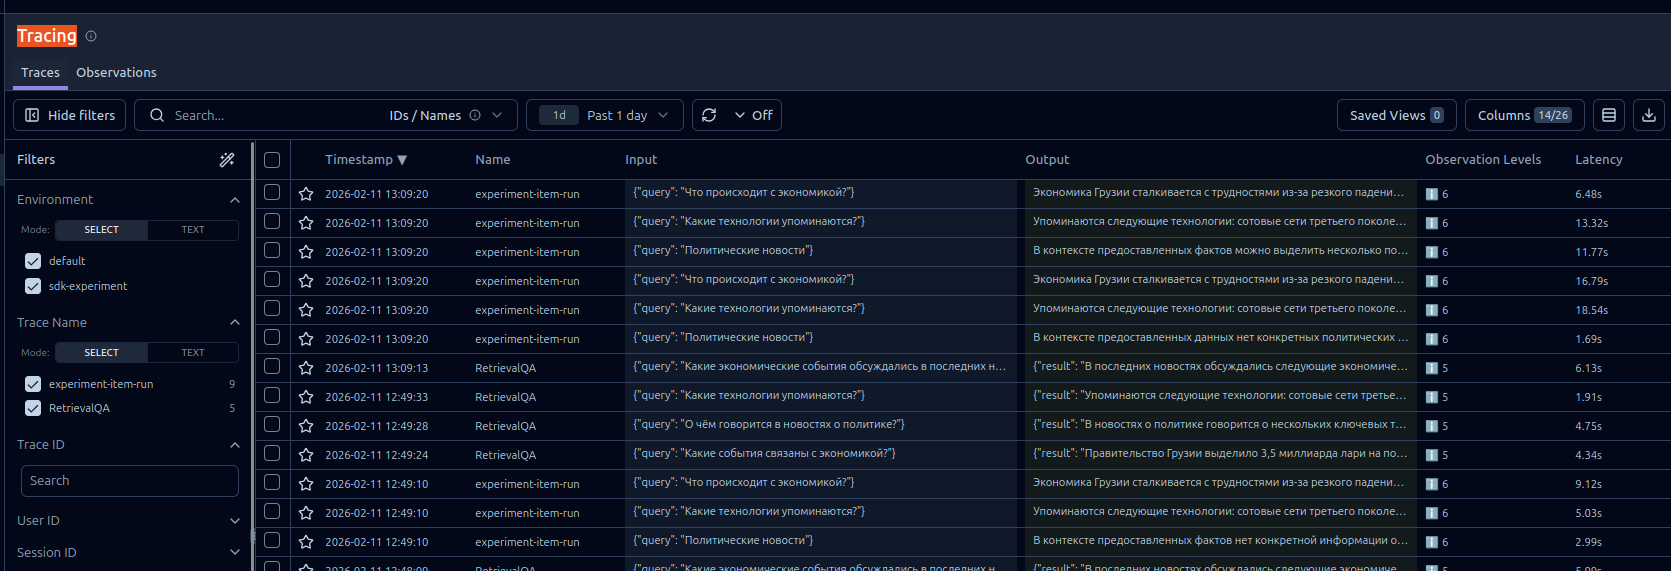

Dataset
hw12-rag-news-eval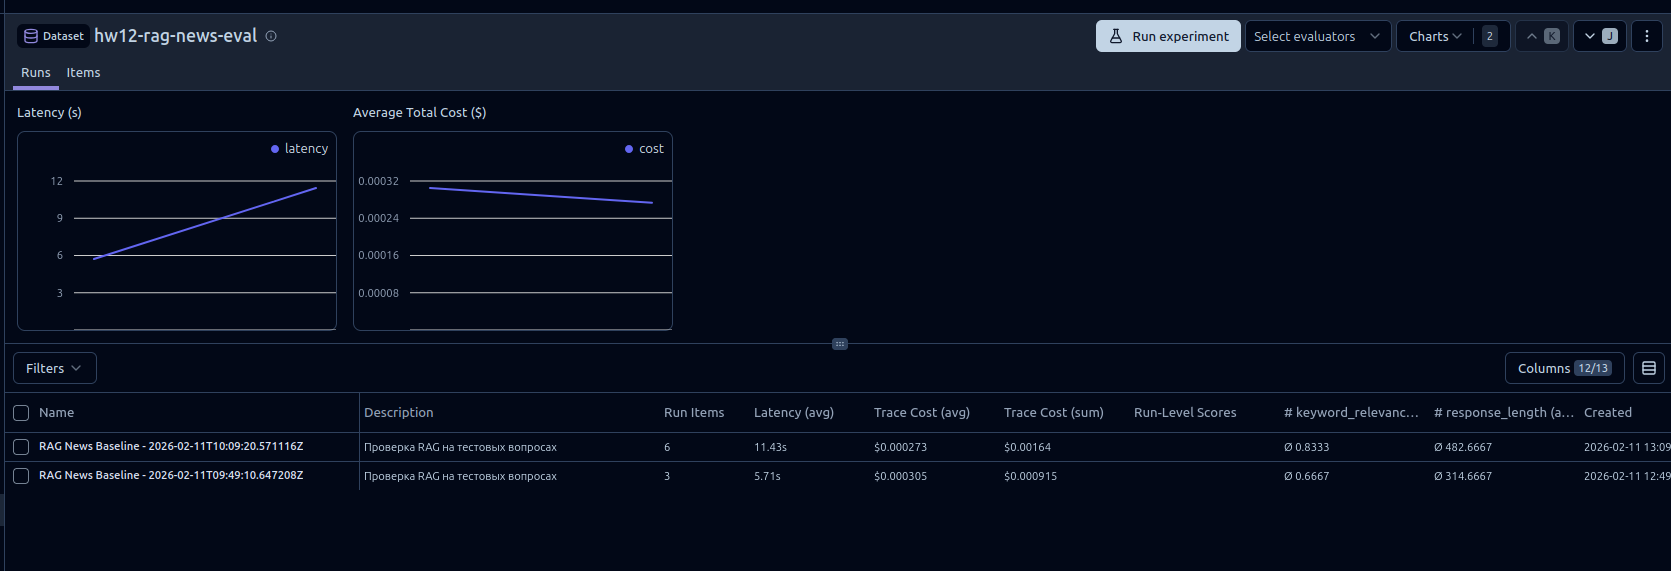

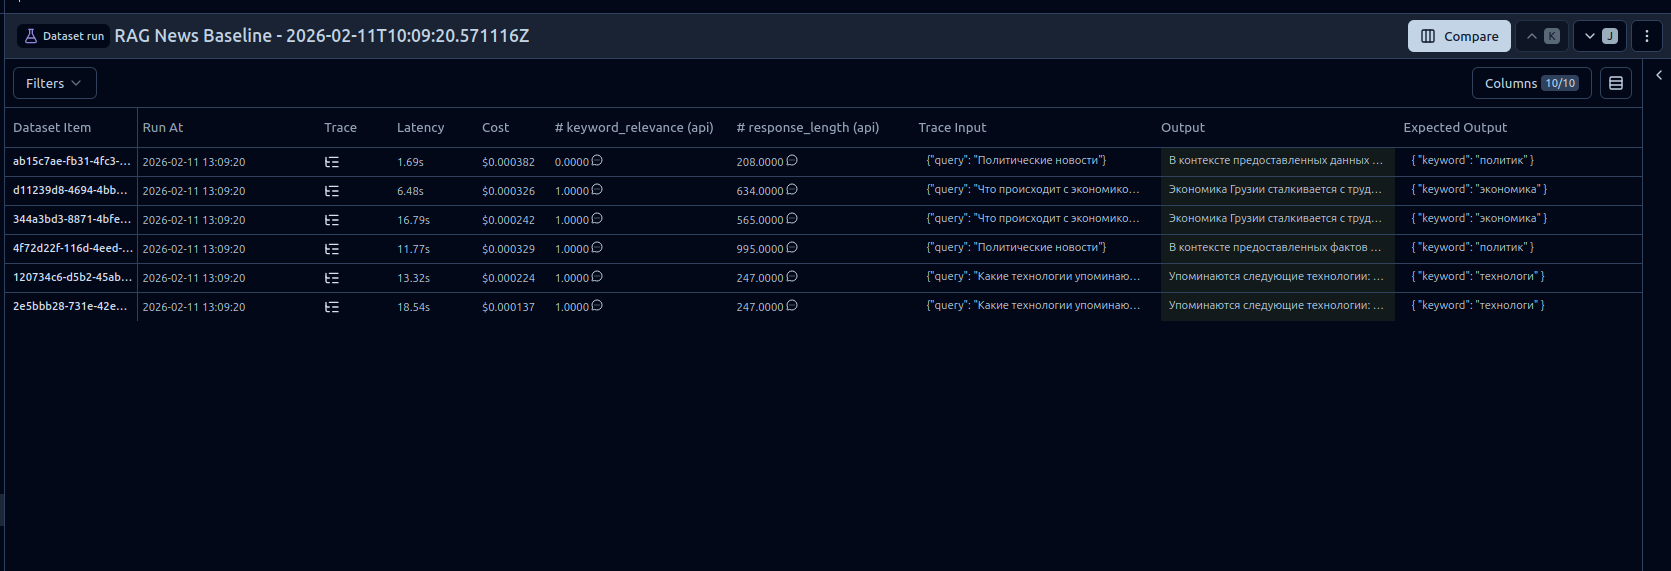